# Data Preprccesing

In [ ]:
!pip install gensim
!pip install hazm
!pip install arabic_reshaper
!pip install python-bidi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hazm import word_tokenize
from heapq import nlargest
from gensim.test.utils import datapath
from gensim import utils
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.feature_extraction.text import TfidfVectorizer

reading data , spliting documents and labels

In [ ]:
data = pd.DataFrame(columns=['doc' , 'topic'])

with open('/content/drive/MyDrive/nlp/HW2/Hamshahri.txt',  encoding = 'UTF-8') as file:
    data_lines = file.readlines()
    for line_idx in range(len(data_lines)):
        line = data_lines[line_idx]
        splited_line = line.split('@@@@@@@@@@')
        data = data.append({'doc' : splited_line[1][:-1]  , 'topic' : splited_line[0] } , ignore_index = True)


In [ ]:
data

,doc,topic
0,جشنواره بین المللی موسیقی امروز آغاز می شود ب...,ادب و هنر
1,پرسپولیس دستخوش تغییرات مدیریتی می شود ورزش ف...,ورزش
2,رئیس جمهوری در خراسان گروه سیاسی حجت الاسلام ...,سیاسی
3,به مناسبت هفته دولت رئیس مجلس یاد شهیدان رجای...,سیاسی
4,براثر سانحه رانندگی نماینده مردم بوئین زهرا د...,اجتماعی
...,...,...
8594,خانه کارگر سازمان تامین اجتماعی باید در اختیا...,اقتصاد
8595,مدیر عامل بانک رفاه در گفت و گو با همشهری بان...,اقتصاد
8596,مجلس مواد قانونی مورد استناد برای تعطیلی مطبو...,اجتماعی
8597,داستانی برای همه فصول نگاهی دوباره به دن کیشو...,ادب و هنر


loading a list of 778 presian stop word 

In [ ]:
stopwords=[]
with open( '/content/drive/MyDrive/nlp/HW2/stop_words.txt',  encoding = 'UTF-8') as file:
  data_lines = file.readlines()
  for line_idx in range(len(data_lines)):
      stopwords.append(data_lines[line_idx][:-1])

In [ ]:
len(stopwords)

778

a function that take a document filter stop words and return a free stop word document

In [ ]:
def filter_stopwords(doc):
  d = word_tokenize(doc)
  for s_word in stopwords:
    try: 
      while(1):
        d.remove(s_word)
    except : pass
  ss= ''
  for i in d:
    ss += (i +' ') 
  return ss

In [ ]:
data_stopwordless=pd.DataFrame()
data_stopwordless['doc'] = data['doc'].apply(filter_stopwords)

In [ ]:
data_stopwordless

,doc
0,جشنواره المللی موسیقی آغاز مسابقه جشنواره شامل...
1,پرسپولیس دستخوش تغییرات مدیریتی ورزش فوتبال اق...
2,رئیس جمهوری خراسان گروه سیاسی حجت الاسلام والم...
3,مناسبت هفته دولت رئیس مجلس یاد شهیدان رجایی با...
4,براثر سانحه رانندگی نماینده بوئین زهرا بیمارست...
...,...
8594,خانه کارگر سازمان تامین اجتماعی اختیار گروه کا...
8595,مدیر عامل بانک رفاه همشهری بانک رفاه کارگران ن...
8596,مجلس مواد قانونی استناد تعطیلی مطبوعات بررسی گ...
8597,داستانی فصول نگاهی دن کیشوت سروانتس نقطه عطف ا...


# Embedding


## skip-gram model

Corpus class with a generator for generating words of each document

In [ ]:
class MyCorpus:
    def __init__(self,data):
      self.data = data_stopwordless
      self.data['tokens'] = self.data['doc'].apply(word_tokenize)

    def __iter__(self):
        for n in range(len(self.data)):
          yield self.data['tokens'][n]

training a gensim word2vec model

In [ ]:
import gensim.models
sentences = MyCorpus(data_stopwordless)
model = gensim.models.Word2Vec(sentences=sentences , sg= 1 , size = 300 )

most similar words to the word 'فوتبال'

In [ ]:
# print(model.most_similar(positive= 'هنر', topn=10))
for i in model.most_similar(positive= 'فوتبال', topn=10):
  print(i)

('باشگاهی', 0.6346694231033325)
('ونگلوس', 0.612361490726471)
('ایویچ', 0.6085985898971558)
('فیفا', 0.6048627495765686)
('فوتسال', 0.6011633276939392)
('ستارگان', 0.5964178442955017)
('بلاتر', 0.5948675870895386)
('آسیاست', 0.5947573184967041)
('تیمهای', 0.5916184186935425)
('بسکتبال', 0.5907583832740784)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


a functon that represent any document with weighted or nonweighted mean of its conataining words

In [ ]:
def document_representation(data , model , weights = None ):
  _data = data.copy()
  _data['tokens'] = _data['doc'].apply(word_tokenize)
  _data['mean_doc'] = 0
  mean_doc_vec = list(len(_data) * '0')
  for d in range(len(_data)):
    vec_list = []
    weight_list = []
    for word in _data['tokens'][d]:
      if weights == None:
        try: vec_list.append(model[word])
        except : pass
      else:
        try: 
          (x,y) = (weights[d][word] , model[word] )
          weight_list.append(x)
          vec_list.append(y)
        except : pass
    if weights == None: mean_doc_vec[d] = np.mean(vec_list , axis=0)
    else :  mean_doc_vec[d] = np.average(vec_list , weights= weight_list , axis=0)
  _data['mean_doc'] = mean_doc_vec
  return _data['mean_doc']

In [ ]:
doc_rep1 = document_representation(data_stopwordless , model , weights = None )
model.similar_by_vector(doc_rep1[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


[('درجشنواره', 0.8795793056488037),
 ('میزگردی', 0.8556028604507446),
 ('همایشهای', 0.8391546010971069),
 ('صربستان', 0.8370053172111511),
 ('مستندسازان', 0.8361352682113647),
 ('کلاردشت', 0.8282492160797119),
 ('خوارزمی', 0.8277875185012817),
 ('ونکوور', 0.826371431350708),
 ('وسومین', 0.8251444697380066),
 ('هجدهمین', 0.8244458436965942)]

calculating tf-idf 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2 , sublinear_tf = True , use_idf = True)
tfidf = tfidf_vectorizer.fit_transform(data_stopwordless['doc'])

In [ ]:
tfidf_doc_word = []
f_names = np.array(tfidf_vectorizer.get_feature_names())
for i in range(len(data)):
   _ , index = tfidf[i].nonzero()
   my_dict = dict(zip(f_names[index].tolist(), tfidf[i , index].toarray().reshape(-1)))
   tfidf_doc_word.append(my_dict)

In [ ]:
doc_rep2 = document_representation(data_stopwordless , model , weights = tfidf_doc_word )
model.similar_by_vector(doc_rep2[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


[('موسیقی', 0.8435825109481812),
 ('درجشنواره', 0.7887652516365051),
 ('خوانندگی', 0.7526266574859619),
 ('مستندساز', 0.7514504790306091),
 ('چکناوریان', 0.7498195767402649),
 ('اجراهای', 0.748239278793335),
 ('هجدهمین', 0.7459216713905334),
 ('نوازندگان', 0.7439624071121216),
 ('ریفی', 0.7438907027244568),
 ('دوسالانه', 0.7438660860061646)]

loading pre-trained word representation vectors

In [ ]:
pretrained_vector = {}
with open('/content/drive/MyDrive/nlp/HW2/hamshahri.fa.text.300.vec',  encoding = 'UTF-8') as file:
    data_lines = file.readlines()
    for line_idx in range(1,len(data_lines)):
        line = data_lines[line_idx]
        splited_line = line.split(' ')
        pretrained_vector[splited_line[0]] = np.array(splited_line[1:]).astype('float64')

In [ ]:
doc_rep3 = document_representation(data_stopwordless , pretrained_vector , weights = None )

In [ ]:
doc_rep4 = document_representation(data_stopwordless , pretrained_vector , weights = tfidf_doc_word )

## LSA Model

calculating tf

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = tf_vectorizer.fit_transform(data_stopwordless['doc'])

SVD matrix factorization

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7)
svd_vector = svd.fit_transform(tf)

In [ ]:
svd_vector.shape

(8599, 300)

In [ ]:
lda = LatentDirichletAllocation(n_components=20, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_vector = lda.fit_transform(tf)

# Clustering

choosing a vector representation as train data

In [ ]:
train_data =np.array(doc_rep1.values.tolist())
train_data.shape
# train_data = svd_vector
# train_data = lda_vector

(8599, 300)

training a k-means clustering model

In [ ]:
from sklearn.cluster import KMeans
K = 5
kmeans = KMeans(n_clusters= K ).fit(train_data)

In [ ]:
labels = kmeans.labels_

In [ ]:
from collections import Counter

def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

def replace(x , y , input_list):
  return [y if item==x else item for item in input_list]

finde the most frequent label in each cluster and choose it as the cluster label

In [ ]:
label_cluster = []
for i in range(len(data)):
  l = labels[i]
  c = data['topic'][i]
  label_cluster.append((c,l))

main_labels = []
for l in range(K):
  lab = [ll[0] for ll in label_cluster if ll[1]==l]
  main_labels.append((most_frequent(lab) , l))

main_labels

[('ورزش', 0), ('سیاسی', 1), ('اقتصاد', 2), ('اقتصاد', 3), ('اجتماعی', 4)]

In [ ]:
for l in main_labels:
  labels = replace(l[1] , l[0] , labels)

labels = np.array(labels)
labels.shape

(8599,)

Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
true_label = data['topic']
accuracy_score(true_label, labels)

0.7476450750087219

F-Measure

In [ ]:
from sklearn.metrics import f1_score
f1_score(true_label, labels , average='weighted')

0.7208717236069403

NMI

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(true_label, labels)

0.6211308670380395

# Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
# tf = tf_vectorizer.fit_transform(data_stopwordless['doc'])

making a LDA model with tf

In [ ]:
lda = LatentDirichletAllocation(n_components=5, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
lda.components_.shape
lda.transform(tf).shape

(8599, 5)

ilustrating top word of each topic

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65010 missing from current font.
  font.set_text(s, 0, flags=flags)


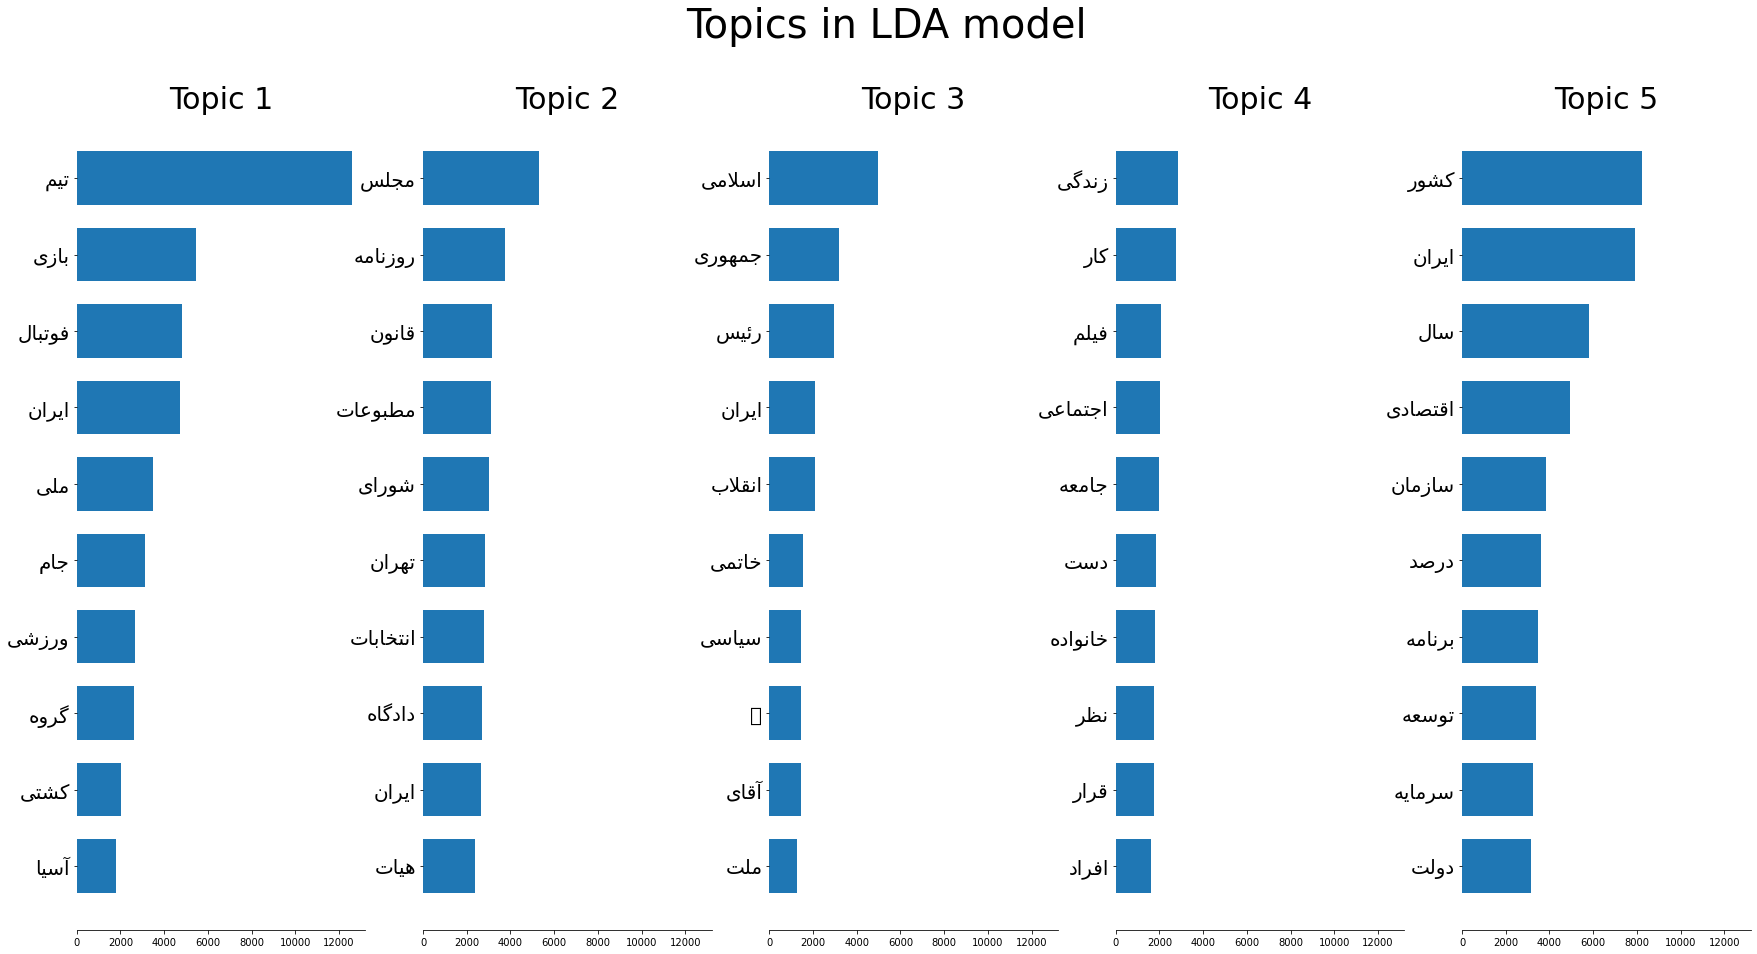

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [get_display(arabic_reshaper.reshape(i)) for i in top_features]

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7 )
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='y', which='both', labelsize= 20 )
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, 10, 'Topics in LDA model')


documents topic assignment

In [ ]:
topic_doc = lda.transform(tf)
lda_label = np.zeros(len(data))
for i in range(len(data)):
  lda_label[i] = np.argmax(topic_doc[i])

documents labeling

In [ ]:
list1 = []
for i in range(len(data)):
  l = lda_label[i]
  t = data['topic'][i]
  list1.append((t,l))

main_labels = []
for l in range(5):
  lab = [ll[0] for ll in list1 if ll[1]==l]
  main_labels.append((most_frequent(lab) , l))
main_labels

[('ورزش', 0), ('سیاسی', 1), ('سیاسی', 2), ('اجتماعی', 3), ('اقتصاد', 4)]

In [ ]:
for l in main_labels:
  lda_label = replace(l[1] , l[0] , lda_label)

lda_label = np.array(lda_label)
lda_label

array(['اجتماعی', 'اقتصاد', 'سیاسی', ..., 'سیاسی', 'اجتماعی', 'سیاسی'],
      dtype='<U7')

Accuracy

In [ ]:
true_label = data['topic']
accuracy_score(true_label, lda_label)

0.7045005233166647

F-Measure

In [ ]:
f1_score(true_label, lda_label , average='weighted')

0.6684964667480401

NMI

In [ ]:
normalized_mutual_info_score(true_label, lda_label)

0.5563954736142461